# Importing packages

In [43]:
#Importing Packages.
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader,ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

The imported Python code is initializing the necessary packages to build an image classification model using PyTorch.

It starts by importing common packages like NumPy for numerical computing and matplotlib for plotting.

Then it imports PyTorch, which is a popular framework for building neural networks. Specifically it imports torch for the main PyTorch library and torch.utils.data for datasets and data loading.

The glob module is imported to help load image files from disk.

Sklearn's confusion_matrix and accuracy_score are imported to help evaluate the model later.

Finally OpenCV (cv2) is imported for image processing and augmentation during training.

Overall this code is bringing in the key ingredients needed to build an image classifier with PyTorch - the neural network library itself, helpers for data loading and preprocessing, and utilities for evaluation and visualization. It doesn't do any actual model building yet, just prepares the environment with the required tools.

In [44]:
#Loading the image files yes to the tumor array.
tumor=[]
path='./Testing/yes/*.jpg'
for i in glob.iglob(path):
    img=cv2.imread(i)
    img=cv2.resize(img,(128,128))#Changing the shapes of the images for consistency img reading
    b , g, r=cv2.split(img)
    img=cv2.merge([r,g,b])
    tumor.append(img)

Explanation of the image loading loop:

This loop iterates through a set of image files and loads each one, processes it, and adds it to a list called tumor.

It takes as input path, which contains the file path to a folder of .jpg images.

For each image file matched by path, it:

Uses cv2.imread() to load the image file into a variable called img.

Resizes the image to 128x128 pixels using cv2.resize() to make all images a consistent size. This is important for processing them consistently later.

Splits the image into individual blue, green, and red color channels using cv2.split().

Merges the color channels back together in a different order, red first instead of blue, using cv2.merge(). This reorders the colors.

Adds the processed image to the list tumor using .append().

By the end, tumor contains all the image files loaded and processed. They are all resized to 128x128 and have their colors reordered. This standardizes the images for future processing steps. The loop allows efficient batch loading and processing of multiple image files using iterative logic.

In [45]:
#Loading of non tumor image files to the array.
no_tumor=[]
path2='./Testing/no_tumor/*.jpg'
for i in glob.iglob(path2):
    img=cv2.imread(i)
    img=cv2.resize(img,(128,128))#Changing the shapes of the images for consistency img reading
    b , g, r=cv2.split(img)
    img=cv2.merge([r,g,b])
    no_tumor.append(img)

This code loads JPG image files from a folder into a Python list called no_tumor.

It takes as input path2, which contains the path to a folder of JPG images that do not contain tumors.

For each image file matched by path2, it:

Uses cv2.imread() to load the image file into a variable called img.

Resizes the image to 128x128 pixels using cv2.resize() to make all images a consistent size.

Splits the image into blue, green, and red channels using cv2.split().

Merges the channels back together in a different order using cv2.merge() - red, then green, then blue. This reorders the color channels.

Adds the processed image to the list no_tumor using .append().

After iterating through all image files, no_tumor will contain all non-tumor images, resized to 128x128 pixels with their color channels reordered.

This standardizes the images by making them a consistent size and channel order. The loop allows efficient batch loading and processing of the image dataset.

In [46]:
no_tumor=np.array(no_tumor)
tumor=np.array(tumor)
All=np.concatenate((no_tumor,tumor))

It first converts the no_tumor list into a NumPy array using np.array().

It also converts the tumor list into a NumPy array.

It concatenates the two arrays together into one big array called All using np.concatenate().

So in summary, it is taking the two image lists, converting them into NumPy array format, and then joining them together into one combined array.

The main purpose is to convert the lists into arrays, which allows easier mathematical operations on the data later on. NumPy arrays are more efficient for numerical computations compared to regular Python lists.

Concatenating them into one array joins the non-tumor and tumor images into a single dataset. This combined dataset in All can now be used for training and testing a machine learning model to classify tumor vs non-tumor images.

The key data transformation is going from Python lists to NumPy arrays, which enables easier numerical analysis. And combining the datasets prepares the data for machine learning.

# Visualizing 

In [47]:
def plot_random(no_tumor,tumor,num=5):
    nti=no_tumor[np.random.choice(no_tumor.shape[0], num, replace=False)]
    ti=tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('Tumorfree')
        plt.imshow(nti[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('Tumor')
        plt.imshow(ti[i])

The purpose of this function is to plot a random sample of images from the non-tumor and tumor image arrays for visualization.

It takes as input:

no_tumor: the array of non-tumor images
tumor: the array of tumor images
num (default 5): the number of random images to plot from each array
It first samples num random images from each array using np.random.choice(), storing them in nti and ti.

It then creates a matplotlib plot with subplots to visualize the images:

It creates a figure with big 16x9 inch dimensions for clear visualization.

It loops num times and plots each non-tumor image on its own subplot, with the title 'Tumorfree'.

It creates a second figure and loops again, this time plotting the tumor images on their own subplots, titled 'Tumor'.

So in summary, it allows easy visualization of random samples from both image arrays, by plotting them on subplots with clear titles indicating tumor or non-tumor. This helps visually inspect the image data.

The key logic is sampling from the arrays randomly and using matplotlib subplots to arrange the visualizations cleanly. This provides an informative summary view of the image data.

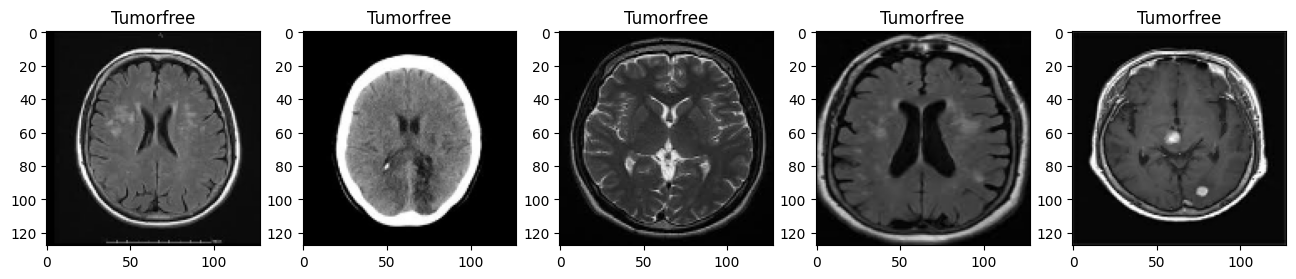

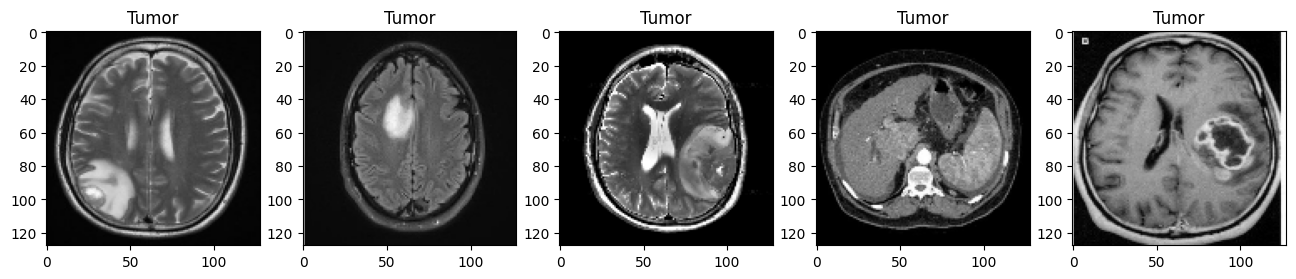

In [48]:
plot_random(no_tumor,tumor,num =5) 

This calls the plot_random function defined previously, passing in:

no_tumor: the array of non-tumor images
tumor: the array of tumor images
num=5: a parameter specifying to plot 5 random images from each array
Inside plot_random(), it will:

Sample 5 random non-tumor images from no_tumor and store in nti

Sample 5 random tumor images from tumor and store in ti

Create a matplotlib figure and plot the 5 non-tumor images on subplots, titled 'Tumorfree'

Create a second figure and plot the 5 tumor images on subplots, titled 'Tumor'

So in summary, this single line of code generates a visualization of 5 random non-tumor and 5 random tumor images from the datasets, arranged nicely with titles using the plot_random() function.

The purpose is to conveniently visualize some example images from both classes to get a sense of the data. The plot_random() function encapsulates the sampling and plotting logic, keeping the client code clean. This is a common pattern in programming.

# PyTorch


## Creating Custom MRI class for pytorch

In [49]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./Testing/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./Testing/no_tumor/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 
                  'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

The init method in the MRI class initializes the dataset by loading and preprocessing the input images.

It takes no explicit inputs.

The outputs are:

self.images - A numpy array containing all the loaded and preprocessed input images.
self.labels - A numpy array containing the labels (1 for tumor, 0 for no tumor) for each corresponding image.
The code first initializes two empty arrays - tumor and no_tumor. It then loops through the image files in the ./Testing/yes and ./Testing/no_tumor directories, reads each image file using cv2.imread(), resizes to a consistent size, splits into RGB channels, merges back to RGB, reshapes and appends to the respective tumor or no_tumor array.

After looping through all images, the tumor and no_tumor arrays are converted to numpy arrays of float32 type. The corresponding labels are created as 1s and 0s of float32 type and same length as images.

Finally, the images and labels arrays are concatenated together to create the final self.images and self.labels attributes that represent the full dataset.

So in summary, the init method loads the input images, preprocesses them, creates the associated labels, and combines them into the final dataset attributes that can be used for training and evaluation. The key steps are reading the image files, preprocessing, and concatenating into the final dataset arrays.





In [50]:
mri=MRI()
mri.normalize()
len(mri)

350

This code snippet initializes an MRI image, normalizes it, and gets the length of it.

First, an MRI object is created and assigned to the variable mri. This will hold the MRI image data.

Next, mri.normalize() is called. This is a method of the MRI class that does some processing on the image data to normalize the values. Normalizing rescales the intensity values so they fall in a standard range, which helps with analyzing and comparing different MRI scans.

After normalizing, len(mri) is called. This gets the length of the mri object, which for an image would be the total number of pixels.

So in summary, this code loads in an MRI image, preprocesses it by normalizing the pixel intensities, and gets the size of the image data. It takes no explicit inputs but uses the MRI class to work with the image data. The outputs are the normalized mri object and the length value. The overall purpose is to load and initialize an MRI image for further analysis and processing.

# Creating a Dataloader


In [53]:
dataloader=DataLoader(mri, batch_size=5, shuffle=True)

This line of code creates a DataLoader object called dataloader. The DataLoader is used to load data from a dataset and prepare it for training a neural network.

It takes two main inputs:

mri - This is the dataset that contains the data we want to load.
batch_size - This specifies the number of samples from the dataset to load at a time. Here it is set to 5.
The DataLoader will iterate through the mri dataset, take batches of 5 samples, and return those batches to use for training.

There are two other important parameters:3) shuffle=True - This tells the DataLoader to randomly shuffle the order of the samples each time it iterates through the dataset. This helps prevent bias in training.

It returns a dataloader object that we can iterate through to get our batches of data.
In summary, this line creates a DataLoader that loads the mri dataset in batches of 5 samples at a time, shuffling the order each iteration. This prepares the data for training by delivering it in small batches instead of all at once. The DataLoader handles the work of batching, shuffling, and sampling the data so the training loop can focus on just optimizing the model.

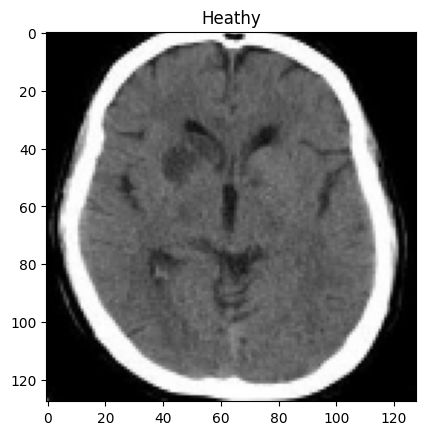

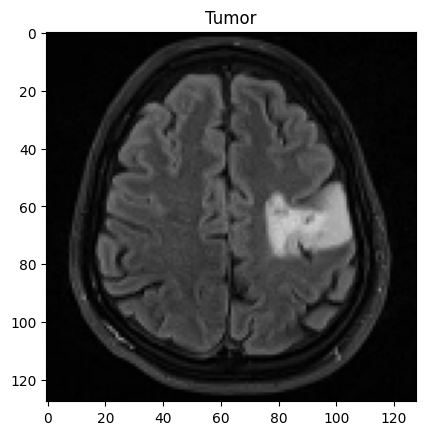

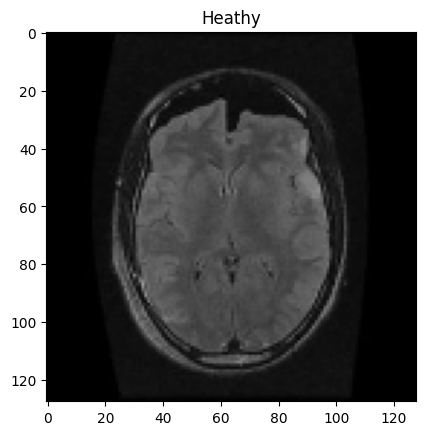

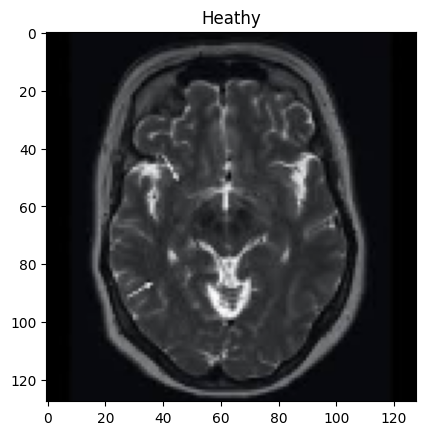

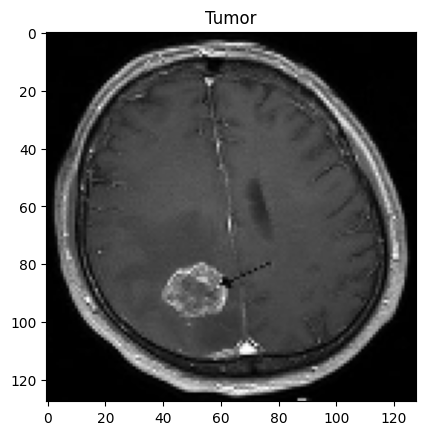

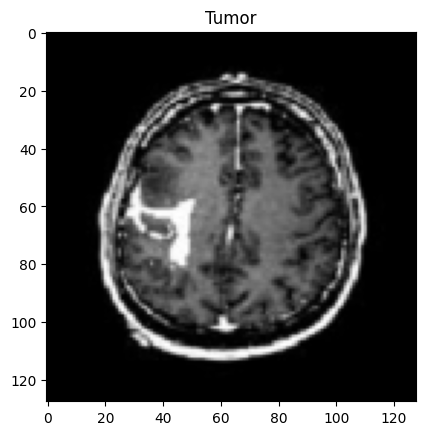

In [75]:

# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break
# Iterates through the DataLoader, displaying a sample image 
# and label from the dataset. Stops after 5 iterations.




## Iterating Through DataLoader

This code iterates through a DataLoader called dataloader, displaying sample images and labels from a dataset.

It takes the dataloader as input, which contains the dataset samples.

The output is a series of sample images displayed with their corresponding labels.

For each iteration i, it gets a sample from dataloader containing an image ('image') and a label ('label'). It squeezes the image to remove any singleton dimensions. Then it reshapes the image dimensions to (height, width, channels) for display.

It displays the image using matplotlib, setting the title to the string name mapped from the numeric label. After showing the image, it checks if 5 iterations have occurred, and if so, breaks out of the loop.

So in summary, this iterates through the first 5 samples from a dataset loader, displays the image and label for each, then stops. This allows quickly previewing some samples from the dataset during development and debugging. The key steps are iterating through the loader, extracting the image and label, reshaping the image, mapping the label to a name, displaying with matplotlib, and breaking after 5 iterations.